**CONSTANT HEIGHT STM IMAGES**
------------------------------


Theory Background
-----------------

Prediction of STM images requires a knowledge of the **electronic structure** of the molecule and a theory of how STM works.

The standard theory of how STM works is based on the Tersoff-Hammann aproximation (https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.50.1998):
**the tunneling current is proportional to the local density of states (LDOS)**:

$$
I(\vec{r}, V) \propto \int_0^V LDOS(\vec{r}, E_f - V + \epsilon) \,d\epsilon\
$$
The LDOS at a certain energy is calculated from the electron density, computed as $\psi(\vec{r}) \psi^*(\vec{r})$, considering only  wavefunctions at that energy.

The value of the tip bias V determines **which states are explored**:  

$V = V_{tip} - V_{sample} > 0$ : sample electrons go to the tip, so the images **show occupied states**.

$V = V_{tip} - V_{sample} < 0$ : tip electrons go to the sample, so the images **show unoccupied states**.

In summary, to compute constant height STM images, we need:

1.- Obtain atomic coordinates (for example, from a previous geometry optimization calculation)

2.- Compute the eigenstates (wavefunction coefficients) and eigenvalues (energies). We will use **SIESTA** for this.

3.- Compute electron density of selected states and compute the STM current $I(\vec{r}, V)$ for any point in space $\vec{r}$ (at a constant height $z$), given the voltage bias $V$. We will use **python** for this.

$$
I(\vec{r}, V) \propto \int_0^V \sum_{i} \left[n(-V + E, \epsilon_i) *  \psi_i(\vec{r}) \psi_i^*(\vec{r})\right] \,dE\
$$

Python implementation of STM simulation
---------------------------------------
We first import of required libraries

In [1]:
import sisl
from sisl import *
import sisl.viz
import numpy as np
import matplotlib.pyplot as plt

**Check Structure and perform SIESTA calculation**

You need atomic coordinates to start (from a previous geometry optimization, for example), centered in the simulation cell. 
Once you have your molecule structure, you will need the Hamiltonian.

If you do not have it you can just run a single calculation from the fdf of the structure telling siesta to store the Hamiltonian using `SaveHS true  `.


In [2]:
serotonin=Geometry.read("optimization.xyz")

In [3]:
print (serotonin)

Geometry{na: 25, no: 25,
 Atoms{species: 4,
  Atom{C, Z: 6, mass(au): 12.01070, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 10,
  Atom{N, Z: 7, mass(au): 14.00670, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 2,
  Atom{H, Z: 1, mass(au): 1.00794, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 12,
  Atom{O, Z: 8, mass(au): 15.99940, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 1,
 },
 maxR: -1.00000,
 Lattice{nsc: [1 1 1],
  origin=[0.0000, 0.0000, 0.0000],
  A=[16.5099, 0.0000, 0.0000],
  B=[0.0000, 17.5903, 0.0000],
  C=[0.0000, 0.0000, 13.8232],
  bc=[Unknown,
      Unknown,
      Unknown]
 }
}


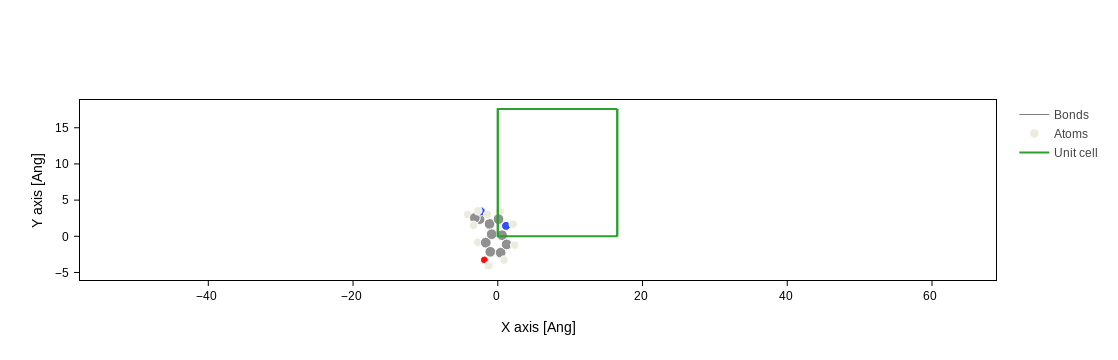

In [4]:
serotonin.plot(axes="xy")

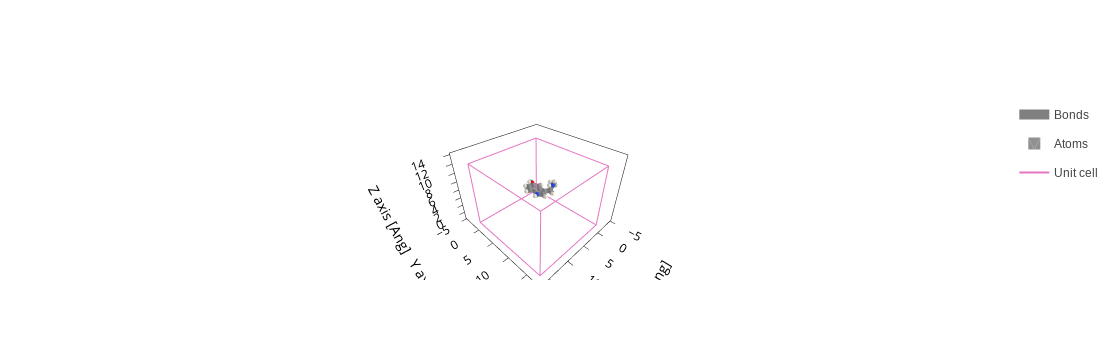

In [5]:
serotonin.plot()

In [6]:
sero_centered=serotonin.move((7,7,5))

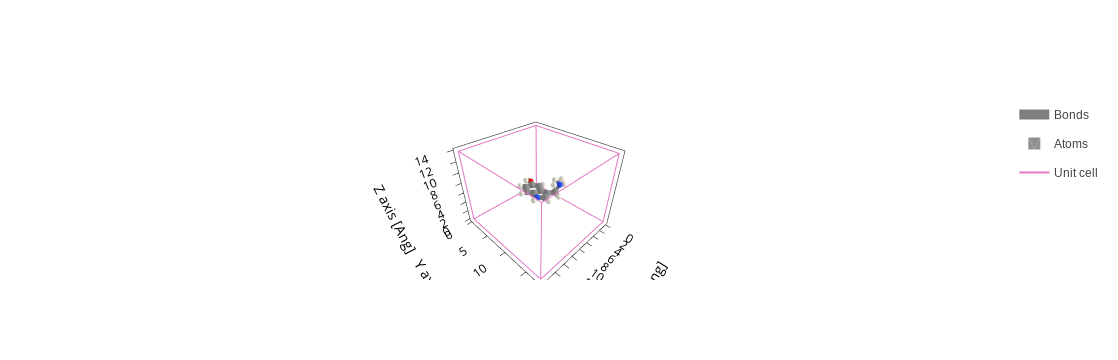

In [7]:
sero_centered.plot()

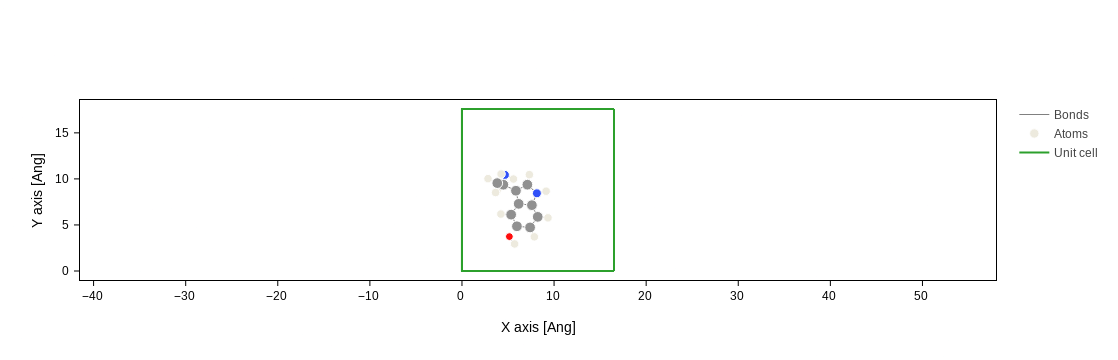

In [8]:
sero_centered.plot(axes="xy")

In [9]:
sero_centered.write("structure.fdf")

## Analysis of SIESTA Results
**Load SIESTA Calculation**

Once the SIESTA run has finished, to load SIESTA results into python you can do:

```python
sisl.get_sile("path/to/my/file.fdf").read_hamiltonian()
```

as we have done in previous lab sessions.

In [10]:
fdf = get_sile("run/stm.fdf")

In [11]:
H = fdf.read_hamiltonian()

In [12]:
print(H)

Hamiltonian{non-zero: 48933, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 25, no: 229,
  Atoms{species: 4,
   Atom{C, Z: 6, mass(au): 12.01100, maxR: 4.00313,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 3.10400910650152, q0: 2.0}},
    AtomicOrbital{2sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 1.7478297099283084, q0: 0.0}},
    AtomicOrbital{2pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 4.0031312515807995, q0: 2.0}},
    AtomicOrbital{2pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 4.0031312515807995, q0: 2.0}},
    AtomicOrbital{2pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 4.0031312515807995, q0: 2.0}},
    AtomicOrbital{2pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 2.2502673795591357, q0: 0.0}},
    AtomicOrbital{2pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 2.2502673795591357, q0: 0.0}},
    AtomicOrbital{2pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 2.2502673795591357, q0: 0.0}},
    AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbital{l: 

In [13]:
molec = H.geometry

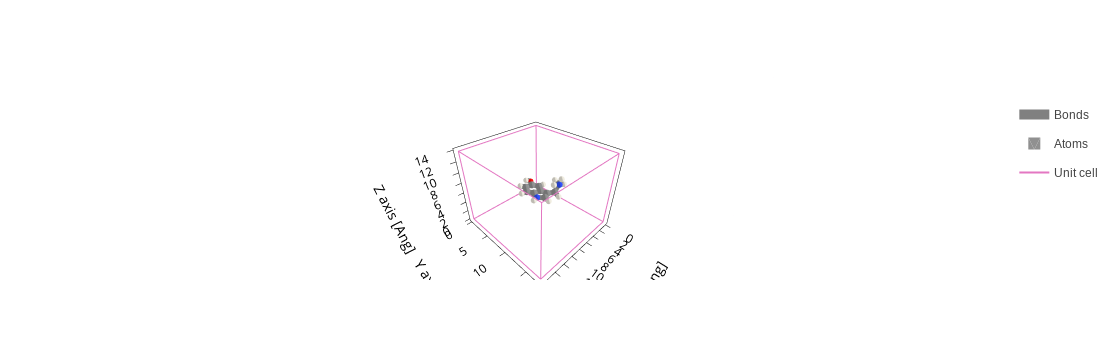

In [14]:
molec.plot()

## Eigenstates

Once you have a hamiltonian, you can get all Eigenstates with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. 
- Each eigenstate has its energy stored under the `.eig` property.
- We can find the HOMO and LUMO.
- We can use the `.dos`  method to obtain the density of states DOS(E).
- In sisl we can plot pdos directly in a given Energy range with something like `H.plot.pdos(data_Erange=[-10,10],nE=1200,Erange=[-10,10]) `

In [15]:
es=H.eigenstate()

In [16]:
print(len(es))

229


In [17]:
es.eig

array([-22.13005665, -20.20756086, -17.56485198, -16.51358979,
       -15.49197182, -14.09813363, -13.85276867, -13.31855861,
       -11.24988165, -10.95750731, -10.93078612,  -9.59994929,
        -9.0264733 ,  -8.61101642,  -7.70045731,  -7.606887  ,
        -7.31134361,  -6.8899228 ,  -6.40803548,  -6.11316269,
        -6.08958177,  -5.58989774,  -5.46632252,  -5.25695417,
        -5.00407868,  -4.74927512,  -4.39602573,  -4.32185316,
        -3.76056671,  -3.24010078,  -2.53390987,  -1.28157329,
        -1.03720661,  -0.70112623,   2.59255611,   3.77087774,
         4.25471152,   4.28997852,   4.35487919,   4.79119391,
         5.11623094,   5.47245503,   5.6396795 ,   6.01123044,
         6.19883867,   6.49850272,   6.78914981,   6.94668683,
         7.13305904,   7.18740781,   7.73969488,   7.94124696,
         8.36184481,   8.42201034,   8.68363471,   8.95027746,
         9.2754804 ,   9.44056199,   9.72937216,   9.90621818,
        10.03343084,  10.26595995,  10.44986058,  10.67

In [18]:
idx_lumo = (es.eig > 0).nonzero()[0][0] #trick to obtain the LUMO as first positive eigenvalue

In [19]:
print(idx_lumo)

34


In [20]:
print("HOMO E=",es.eig[idx_lumo-1]," eV")
print("LUMO E=",es.eig[idx_lumo]," eV")

HOMO E= -0.7011262339075248  eV
LUMO E= 2.592556106334389  eV


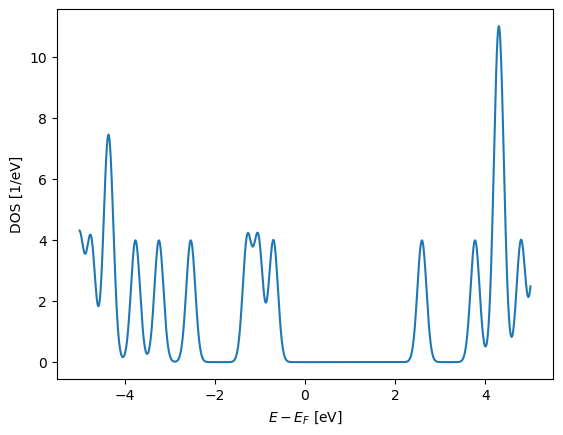

In [21]:
E = np.linspace(-5, 5, 1000)
plt.plot(E, es.DOS(E))
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"DOS [1/eV]");

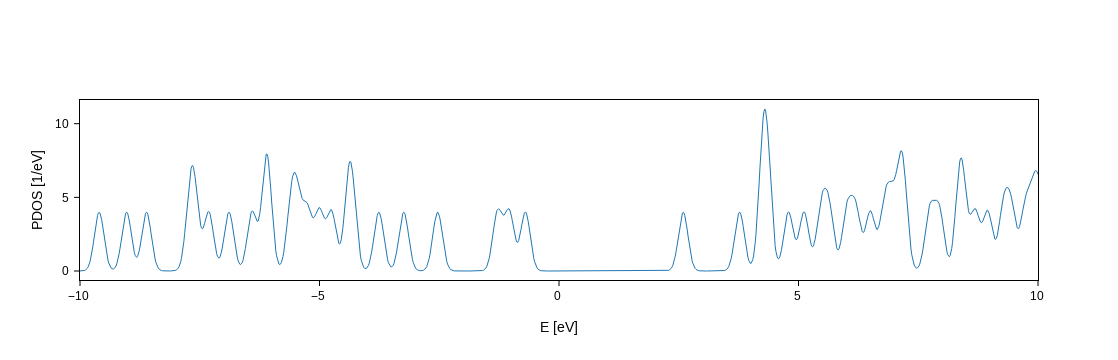

In [22]:
H.plot.pdos(data_Erange=[-10,10],nE=1200,Erange=[-10,10]) 

-----------------------------------------------------------------------------------
## Plotting Local Density of States

Create a grid and fill the grid with LDOS

**To compute wavefunctions on the grid:**

To compute $\psi (\vec{r})$ you need three things.

1. **The eigenstate coefficients.** Once you have a hamiltonian, you can get all of them with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. Each eigenstate has its energy stored under the `.eig` property.
2. **A grid of points in space.** You can create one with `sisl.Grid(geometry, shape=(100, 100, 100))`. This will create a grid of $100x100x100$ points within the cell of your geometry.
3. **A function to project the wavefunction into the grid.** The eigenstate object has a `wavefunction` method ([docs](https://zerothi.github.io/sisl/api/generated/sisl.physics.electron.EigenstateElectron.html#sisl.physics.electron.EigenstateElectron.wavefunction)) that will project the wavefunction into an already initialized grid.
4. Once you have the wavefunction, you can calculate the electron density $\psi_i(\vec{r}) \psi_i^*(\vec{r})$.
5. The result can be saved in a '.cube' file and plotted with VMD 

Remember that we have done this already on the first SIESTA lab, with a water molecule and with $C_{60}$.


Save Electron Density

In [27]:
g = Grid(0.2, lattice=molec.lattice) 

In [28]:
es[idx_lumo].wavefunction(g)
g=g*g.grid.conj() 
g.write('LUMO_dens_sero.cube')
g.fill(0) # reset the grid values to 0

In [30]:
es[idx_lumo-1].wavefunction(g)
g=g*g.grid.conj() 
g.write('HOMO_dens_sero.cube')
g.fill(0) # reset the grid values to 0

# STM images #

**Remember**: The value of the tip bias V determines **which states are explored**:  

$V = V_{tip} - V_{sample} > 0$ : sample electrons go to the tip, so the images **show occupied states**.

$V = V_{tip} - V_{sample} < 0$ : tip electrons go to the sample, so the images **show unoccupied states**.

Now we can create a function `STM_grid(H, V)` that creates a grid adding all the states that contribute to the electron density $\psi_i(\vec{r}) \psi_i^*(\vec{r})$ relevant to the STM image.

The `STM_grid(H, V)` function need the Hamitonian (the object `H`) and the value of the voltage `V`.

In [23]:
def STM_grid(H, V):
    gridT = sisl.Grid((150, 150, 150), geometry=molec)
    grid = sisl.Grid((150, 150, 150), geometry=molec)
    gridT.fill(0)
    E=-V
    for i in range(0,len(es)):
        #Negative V: electrons go from tip to sample filling unoccupied states from 0 to E
        if 0<es[i].eig<E:    
            grid.fill(0)
            print("adding state",i)
            es[i].wavefunction(grid)
            GT=grid*grid.grid.conj()
            gridT=gridT+GT
        #Positive V: electrons with energies between E and 0 leave the sample and go to the tip
        if E<es[i].eig<0:    
            grid.fill(0)
            print("adding state",i)
            es[i].wavefunction(grid)
            GT=grid*grid.grid.conj()
            gridT=gridT+GT 
    result=gridT
    return result

Calculate and save data. IN VMD you can use isosurface or Volume slice representations

In [24]:
V=STM_grid(H, 5)

adding state 25
adding state 26
adding state 27
adding state 28
adding state 29
adding state 30
adding state 31
adding state 32
adding state 33


In [25]:
V.write('STM_5Volt_sero.cube')

In [26]:
V=STM_grid(H, -6)
V.write('STM_m6Volt_sero.cube')

adding state 34
adding state 35
adding state 36
adding state 37
adding state 38
adding state 39
adding state 40
adding state 41
adding state 42
